# P5 - Convolutioneel neuraal netwerk
### Emiel Verhoef, 1760229

# Bronnen:

- hands on machine learning with scikit-learn keras and tensorflow: Chapter 14 - Deep Computer Vision Using Convolutional Neural Networks
- MIT 6.S191 (2020): Convolutional Neural Networks (https://www.youtube.com/watch?v=iaSUYvmCekI)
- Dropout: A Simple Way to Prevent Neural Networks from Overfitting  (https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
- https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/
- https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
- https://paperswithcode.com/sota/image-classification-on-cifar-10


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import random
from sklearn.model_selection import train_test_split
import tensorflow.keras.datasets.cifar10
import keras
from keras_preprocessing.image import ImageDataGenerator
from functools import partial
from confusion_matrix import make_confusion_matrix
from sklearn.metrics import confusion_matrix
from keras.regularizers import l2
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.constraints import max_norm


# Data Preparation

In [2]:
# zonder dit krijg ik een error bij het downloaden van de dataset
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
data = keras.datasets.cifar10.load_data()

In [4]:
label_dict = {0:'airplane', 1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

In [5]:
(X_train, y_train), (X_test, y_test) = data

In [6]:
# one-hot encode the targets
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [7]:
X_train.shape

(50000, 32, 32, 3)

# Data Augmentation
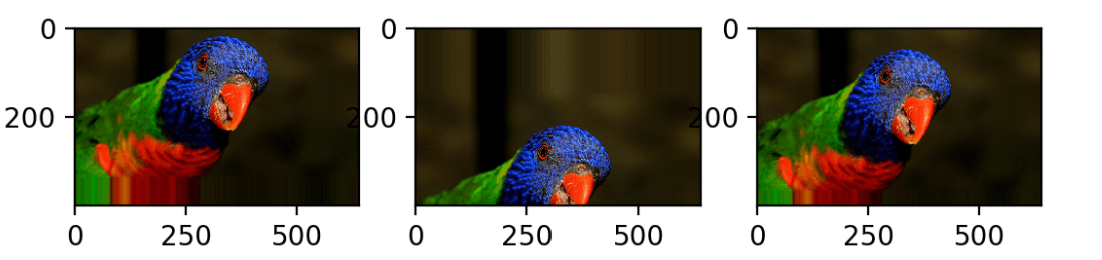
Positief effect op accuracy:

    - horizontal flip

Negatief of geen effect op accuracy:

    - height/width shift
    - rotation
    - zoom
    - brightness



In [8]:
datagen = ImageDataGenerator(horizontal_flip=True)
batch_size = 64
it_train = datagen.flow(X_train, y_train, batch_size=batch_size)
steps = len(X_train)/batch_size


# Het Model

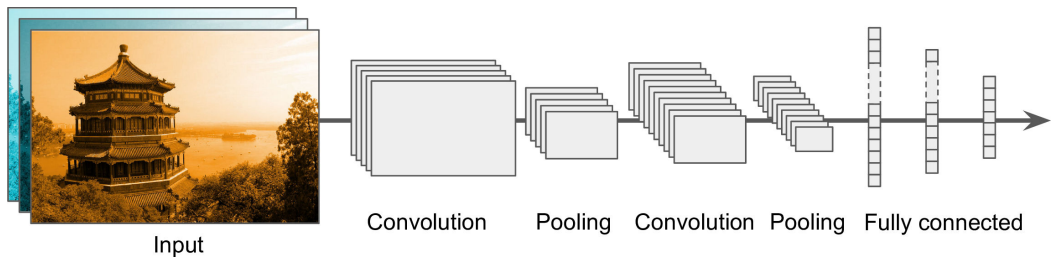

### - Toelichting:
Ik zal zo veel mogelijk proberen uit te leggen waarom ik specifieke variabelen en inputs voor layers kies. Waar ik dit niet doe kan worden aangenomen dat ik default of vaak voorkomende waardes gebruik of de waardes gebruik die het best werken na zelf te hebben geëxperimenteerd. Ik heb alle voorgestelde regularisatiemethodes op canvas uitgeprobeerd, sommige hebben wat problemen met samenwerken (zoals L2 regularization en batch normalization). Ik ben begonnen willekeurig dingen te proberen maar ben uiteindelijk onderzoeken gaan lezen om betere structuur in mijn netwerk aan te brengen. Een groot deel van het eindproduct is vergelijkbaar met VGG structuur.

Dit hele onderdeel van het vak vind ik erg interessant dus ik dan ook veel extra tijd in deze opdracht gestoken. Ik heb één groot model gemaakt i.p.v. twee modellen omdat ik al een stuk meer ervaring met CNN's heb en ik de instructies op canvas over hoe het eerste model precies anders zou moeten zijn van het tweede model niet duidelijk vond ('aanvullende technieken' is voor mij wat betekenisloos omdat ik niet precies weet wat er in de les is behandeld).
### - Rescaling Layers:
In deze layer wordt de input data genormaliseerd, de layer deelt alle waardes door de grootste waarde: 255. Dit zorgt er voor dat ons network sneller kan convergeren.


### - Convolutional Layers:
Convolutional layers worden gebruikt als 'feature extractors'. In een convolutional layer slide een filter (een matrix van x bij y getallen die een patroon representeerd) over onze image bitmap met als doel een map te maken van waar het filterpatroon overeenkomt met een deel van onze image. Dit wordt gedaan door de getallen in het filter te vermenigvuldigen met de getallen van het deel van de de bitmap waar het filter op wordt toegepast en daar de som van te nemen, eventueel een bias er aan toe te voegen, en het in een activatie functie te stoppen.We gebruiken hier de non-lineaire activatiefunctie ReLu voor omdat onze data ook non-lineair is. Dit resultaat is dan één getal in de nieuwe feature map. Hoe vaak dit wordt gedaan is afhankelijk van de grootte van het filter, de grootte van de bitmap, en de strides variabele (de horizontale en verticale stapgrootte). De filters variabele geeft aan hoeveel van deze feature maps, met verschillende filters, worden gemaakt.

Je kan zien dat na elke convolutional + pooling cycle het aantal filters verdubbeld wordt. Dit wordt zo gedaan omdat des te dieper je het netwerk in gaat des te complexer de patronen, en vooral de combinaties van patronen worden. Een van de eerdere convolutional layers kijkt dus bijvoorbeeld naar relatief simpele patronen zoals randen, maar de latere convolutional layers kunnen deze randen samenvoegen om meer complexere vormen te herkennen zoals een vleugel van een vliegtuig. Dit vergt natuurlijk redelijk veel computationele kracht en is dan ook een van de redenen om de volgende twee soorten layers te gebruiken:

### - Dropout Layers:
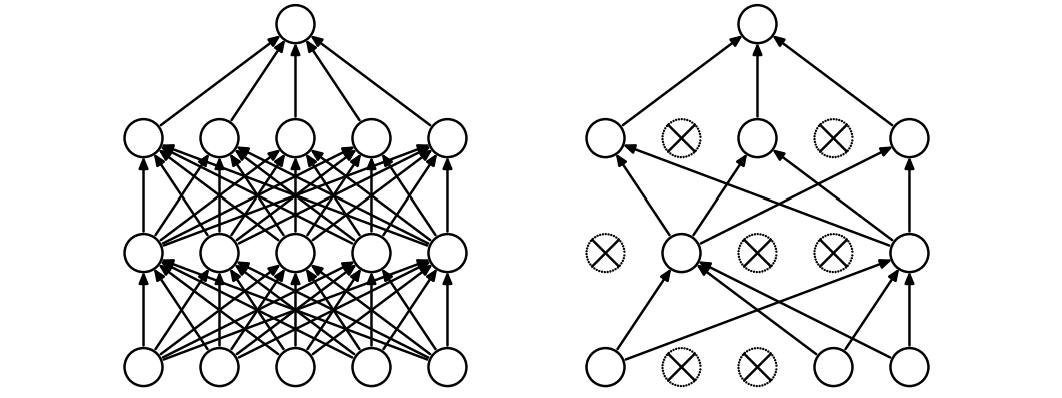
Dropout zorgt er voor dat er een deel van de neurons (en connecties van die neurons) willekeurig worden uitgezet. Dit helpt tegen overfitting omdat neuronen nu niet te veel kunnen afhangen van andere specifieke neuronen (want er is een kans dat deze gedropped worden, en het netwerk moet dan natuurlijk wel goed blijven werken).

### - Batch Normalization Layers:
Net als bij dropout layers is het het doel van batch normalization layers om het netwerk sneller en meer stabiel te maken.

"The weights of a layer are updated given an expectation that the prior layer outputs values with a given distribution. This distribution is likely changed after the weights of the prior layer are updated" dit concept wordt ook wel internal covariate shift genoemd. Het batch normalisatie proces standaardiseerd de activaties van vorige layers wat er voor zorgt dat de aannames van de volgende layers over de distributie van inputs tijdens het weight update proces niet (of nauwelijks) veranderd. In dit netwerk leidt het tot een gigantische verberting in de snelheid van elke epoch (19 -> 12 seconden in de eerste epochs). Maar het zorgt er ook voor dat er significant minder epochs nodig zijn om tot een goed resultaat te komen en dat er minder pieken en dalen zijn in performance. 

### - Pooling Layers:


Waar in onze convolutional layer het filter willekeurig geïnitialiseerd werd werkt het bij pooling layers net even iets anders. Bij max pooling (de methode die ik gebruik) wordt er ook een filter toegepast op de bitmap maar dit filter neemt alleen het grootste getal op het toegepaste deel over naar de feature map. Het maakt in principe dus een soort samenvatting van de bitmap. Dit is een vorm van downsampling. Pooling layers leiden tot een enorme performance gain voor ons netwerk. Dit verminderen van je features kan ook helpen tegen overfitting.

### - Dense Layers:
De dense layer(s) zijn verantwoordelijk voor het classificeren van de extracted features uit de convolutional layers. We gebruiken hier hetzelfde aantal neurons als inputs, dit is standaard. Soms worden er ook 2 of 3 van deze layers gebruikt. Voor dit netwerk heeft dat geen positief effect op de nauwkeurigheid ook duurt het langer om het netwerk te trainen.


### - Output Layer:
De output layer is 10 neurons groot (voor alle 10 de mogelijke image labels). De Softmax activatie functie geeft een kansverdeling als output terug.



### - Optimizers:
Ik heb Adam en SGD(met verschillende lr en momentum waardes) uitgeprobeerd. Adam scoort zo'n 2% hoger op accuracy dan het best werkende SGD model.

### - Callbacks:
Ik gebruik een early stopping callback die na 10 keer geen verbetering in de test/validation loss het netwerk stopt. Ik doe dit omdat ik zeker wil weten dat het geen lokale piek/dal is.

Voor SGD heb ik exponential decay en step decay lr-schedulers gebruikt maar deze verbeterden het netwerk niet.

Omdat ik een redelijk hoge patience gebruik voor early stopping kan het zo zijn dat je de peak performance in je model mist. Ik gebruik daarom een checkpoint callback die het model in zijn beste staat opslaat zodat we die later terug in kunnen laden. 

### - Loss Function:
Categorical Cross-Entropy is de default loss functie voor multi-class classification. Dit hoeft niet sparse te worden gedaan omdat we maar 10 targets labels hoeven te one-hot encoden.

### - Metrics:
Ik gebruik accuracy als metric omdat het makkelijk begrijpbaar is. Voor diepere data understanding kan er altijd een confusion matrix worden gemaakt.

### - Kernel Initializers:
Een kernial initializer zorgt voor de initialisatie van de gewichten in een layer. Ik heb He Uniform en Random Normal geprobeerd. Beiden leiden tot vergelijkbare resultaten.

### - Weight Constraints:
Max weight constraints hadden geen effect op de accuracy van het netwerk.

### - Volgorde van Layers:
Zoals als eerder opgemerkt volgt mijn netwerk een aangepaste VGG structuur. Blokken van Convolutional + Pooling layers gevolgd door dense layers. De volgorde van de BatchNormalization, Pooling en Dropout layers is wat ingewikkelder. Er lijkt niet echt een consensus te zijn over een beste volgorde van deze layers, veel van de discussies hierover verwijzen naar een paper met outdated informatie. Ik heb dus elke mogelijke combinatie uitgeprobeerd en ben met het beste resultaat gegaan.

# - Het model (maar nu echt):

In [21]:

# deze parameters worden voor alle convolutional layers gebruikt
DefaultConv2D = partial(keras.layers.Conv2D,
 kernel_size=3, activation='relu', padding="same", kernel_initializer = 'he_uniform')


model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(32, 32, 3)),
    
    DefaultConv2D(filters = 32),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters = 32),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters = 32),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    
    DefaultConv2D(filters = 64),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters = 64),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters = 64),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    DefaultConv2D(filters = 128),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters = 128),
    tf.keras.layers.BatchNormalization(),
    DefaultConv2D(filters = 128),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation = 'relu', kernel_initializer = 'he_uniform'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(10,activation = 'softmax')
])

model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy']
             )




early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              patience=10)
checkpoint = ModelCheckpoint('top_performing_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


history = model.fit(it_train ,epochs = 100,validation_data = (X_test,y_test), callbacks = [early_stop, checkpoint], batch_size = 64)

Epoch 1/100
781/782 [============================>.] - ETA: 0s - loss: 2.1793 - accuracy: 0.3853
Epoch 1: val_accuracy improved from -inf to 0.54260, saving model to top_performing_model.h5
782/782 [==============================] - 13s 16ms/step - loss: 2.1782 - accuracy: 0.3855 - val_loss: 1.3923 - val_accuracy: 0.5426
Epoch 2/100
781/782 [============================>.] - ETA: 0s - loss: 1.2420 - accuracy: 0.5720
Epoch 2: val_accuracy improved from 0.54260 to 0.67370, saving model to top_performing_model.h5
782/782 [==============================] - 12s 15ms/step - loss: 1.2418 - accuracy: 0.5720 - val_loss: 0.9276 - val_accuracy: 0.6737
Epoch 3/100
781/782 [============================>.] - ETA: 0s - loss: 0.9771 - accuracy: 0.6619
Epoch 3: val_accuracy improved from 0.67370 to 0.70290, saving model to top_performing_model.h5
782/782 [==============================] - 12s 15ms/step - loss: 0.9774 - accuracy: 0.6618 - val_loss: 0.8803 - val_accuracy: 0.7029
Epoch 4/100
781/782 [====

780/782 [============================>.] - ETA: 0s - loss: 0.2325 - accuracy: 0.9213
Epoch 27: val_accuracy did not improve from 0.87690
782/782 [==============================] - 13s 16ms/step - loss: 0.2322 - accuracy: 0.9215 - val_loss: 0.4256 - val_accuracy: 0.8702
Epoch 28/100
782/782 [==============================] - ETA: 0s - loss: 0.2254 - accuracy: 0.9223
Epoch 28: val_accuracy improved from 0.87690 to 0.88130, saving model to top_performing_model.h5
782/782 [==============================] - 13s 16ms/step - loss: 0.2254 - accuracy: 0.9223 - val_loss: 0.3915 - val_accuracy: 0.8813
Epoch 29/100
781/782 [============================>.] - ETA: 0s - loss: 0.2178 - accuracy: 0.9246
Epoch 29: val_accuracy did not improve from 0.88130
782/782 [==============================] - 13s 16ms/step - loss: 0.2178 - accuracy: 0.9246 - val_loss: 0.4307 - val_accuracy: 0.8723
Epoch 30/100
782/782 [==============================] - ETA: 0s - loss: 0.2159 - accuracy: 0.9255
Epoch 30: val_accurac

# Model Evaluatie:

In [22]:
model = load_model('top_performing_model.h5')

In [23]:
def random_classification():
    index = random.randint(0,len(X_test)-1)
    prediction = model.predict(np.expand_dims(X_test[index], axis = 0))
    label = label_dict[np.argmax(y_test[index])]
    predicted_label = label_dict[np.argmax(prediction)]
    plt.imshow(X_test[index])
    plt.title(f"Real: {label} \nPrediction: {predicted_label}\n", color = 'green' if label == predicted_label else 'red')
    plt.show()


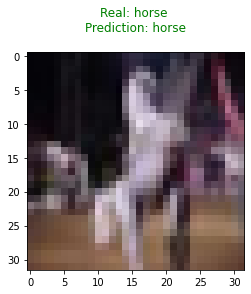

In [24]:
random_classification()

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_10 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_11 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 32)       

In [26]:
def plot_loss(history):
    
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    
    
def plot_accuracy(history):
    
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()

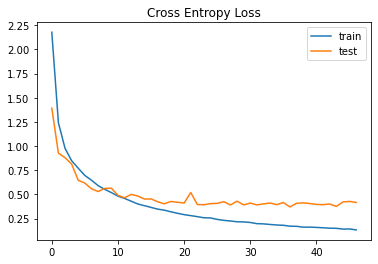

In [27]:
plot_loss(history)

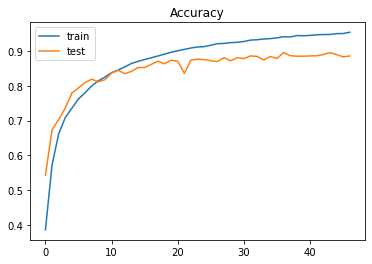

In [28]:
plot_accuracy(history)

In [29]:
test_preds = model.predict(X_test)
test_preds_num = [label_dict[tf.argmax(x).numpy()] for x in test_preds]

In [30]:
cm = confusion_matrix([label_dict[np.argmax(x)] for x in y_test],test_preds_num)

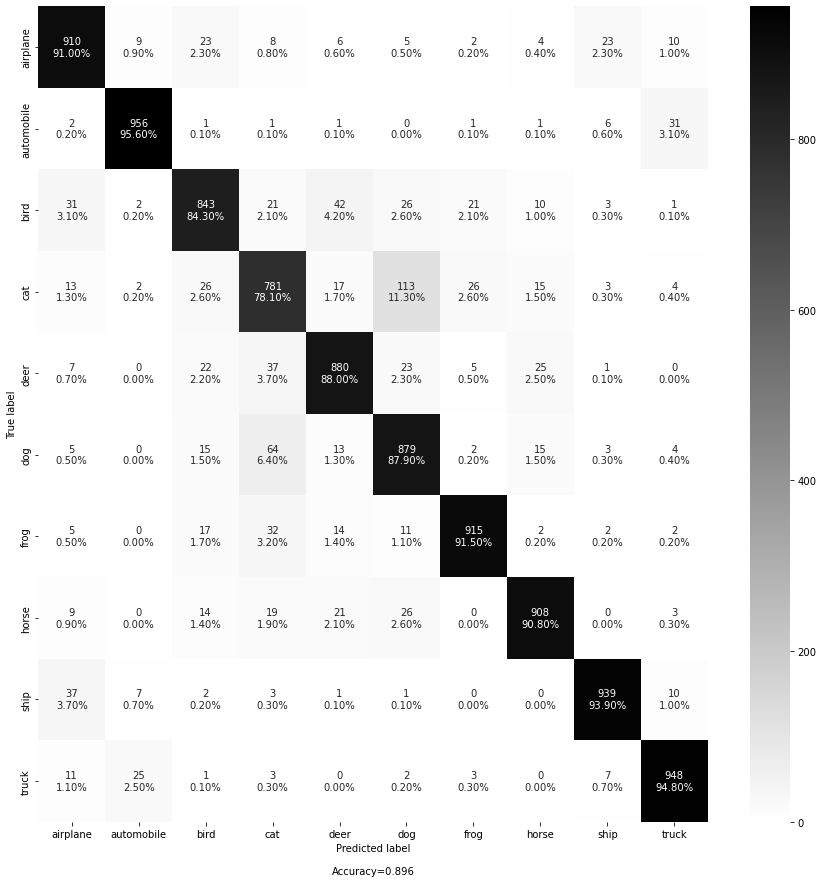

In [31]:
make_confusion_matrix(cm, 
                      cmap= 'binary',
                      figsize = (15,15),
                      categories = list(label_dict.values()))

plt.show()

In de confusion matrix zie je clusters vormen van vergelijkbare objecten die regelmatig met elkaar verward worden. Een grote cluster in het midden: de verschillende dieren. En een cluster in de hoeken: de voertuigen. Het is interessant om te zien dat honden en katten relatief vaak met elkaar verward worden, maar dat herten veel vaker correct geclassificeerd worden. Dit is mogelijk te verklaren door unieke identifiers zoals: een bosomgeving als achtergrond, een gewei, of de relatieve grootte van een hert in vergelijking met de andere dieren. Katten en honden lijken veel meer op elkaar en komen voor in dezelfde soort omgeving.



# Conclusie:
Op z'n best heeft mijn netwerk een nauwkeurigheid van 90%. Dit lijkt te matchen met de top accuracy van oudere deep convolutional neural networks.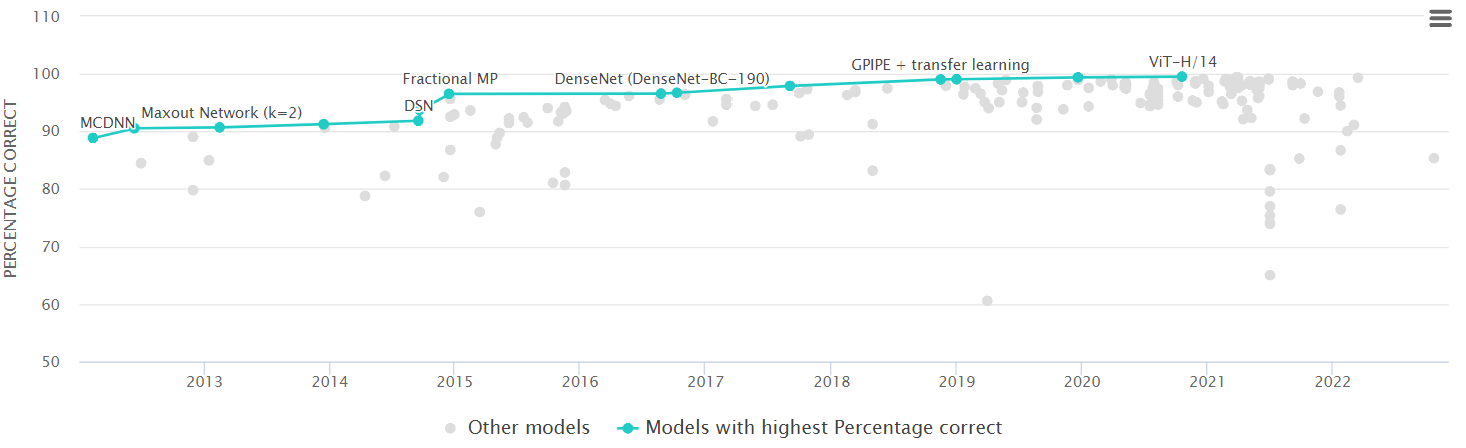

Zoals je in de loss/accuracy grafieken kan zien vindt het grootste deel van de accuracy gain plaats in de eerste ~14 epochs (84% accuracy). Het duurt nog zo'n 30 extra epochs om de accuracy van ~89% te bereiken. Dit geeft de indruk van overfitting, vooral omdat de test en train accuracy redelijk wat uit elkaar beginnen te lopen, maar er blijft wel significante test accuracy gain plaatsvinden. Of dit het waard is is discutabel.

Als leuke uitbreiding van deze opdracht lijkt het me ook interessant om precies dezelfde netwerk structuur (met een andere output layer) in te zetten voor een andere 32x32 image dataset. Ik verwacht dat het hier ook goed voor zou werken.